# Implementierung einer Support Vector Maschine (SVM) zur klassifizierung von Zahlen
Das Notebook beschreibt die Implementierung einer Support Vector Maschine für das klassifizieren von Bildern. Wie schon im Storyboard besprochen geht es um das Klassifizieren von Zahlen. 

## Aufbau:
Der Aufbau des Notebooks ist in drei grobe Teile geteilt. Zuerst wird der Datensatz eingelesen und vorbereitet. Anschließend wird das Modell definiert und trainiert. Abschließend wird die SVM anhand eines Webcam-Videostreams angewendet. 
### Abschnitt 1: Datensatz vorbereiten
Im ersten Teil des Notebooks wird der Datensatz vorbereitet. Hierzu wird ein [Dictonary](https://kapernikov.com/tutorial-image-classification-with-scikit-learn/) angelegt. Anschließend kann mit dem Dictonary eine reshape Funktion aufgerufen werden, um die Bildmatrizen in einen Vektor umzuwandeln, wie auch schon in der Theorie besprochen wurde. 
### Abschnitt 2: Erstellen des Modells
In diesem Abschnitt wird das Modell mittels der [sklearn-Bibliothek](https://scikit-learn.org/stable/modules/svm.html) definiert. Dies ist auch der Abschnitt, bei dem Parameter eingestellt werden können. Abschließend wird das Modell trainiert und getestet. Ebenso sieht man den Plot des Trainingsverlaufs. 
### Abschnitt 3: Testen 
Im letzten Abschnitt wird das trainierte Modell eingesetzt. Die SVM klassifiziert jedes neue Bild im Demo Ordner, gibt an welche Zahl abgebildet ist und gibt diese aus. 



## Ordnerstruktur: 
Anbei ist noch die Ordnerstruktur aufgelistet. Zu dem Use Case gehören 2 Ordner und 3 Dateien. Der Demo Ordner wir für die Implementierung selbst nicht verwendet. Dieser beinhaltet nur Darstellungen für die Beschreibungen im Notebook/Storyboard. Der Data Ordner gibt hingegen die beiden Klassen vor. Hier müssen Unterordner existieren, welche auch gleich die Klassennamen vorgeben. In unserem Fall sind das die Zahlen 0 bis 9. Diese Unterordner beinhalten die Bilder, welche zum Trainieren eingesetzt werden sollen. 

Die Datei workspace_detection_{width}x{height}px.pkl ist eine Datei, die im Laufe des Notebooks generiert wird und den Datensatz als [Dictonary](https://kapernikov.com/tutorial-image-classification-with-scikit-learn/) abspeichert. Die Datei *.ipynb ist das Notebook selbst. Die dritte Datei in für den Use Case ist die requirements Datei. Diese kann eingesetzt werden, um die benötigten Bibliotheken und Systemvoraussetzungen zu installieren. Ein (externes) Tutorial dazu findet man [hier](https://note.nkmk.me/en/python-pip-install-requirements/). 

## Ordnerstruktur: 
1. demo [Ordner]
    - _demo images_
2. data [Ordner]
    - Hier kann der Datensatz geändert werden
3. eigenfaces [Ordner]
    - Top 10 Eigenfaces der PCA

4. `miniUsecase12_SVM.ipynb` [Beispielcode]

5. `MNIST{width}x{height}px.pkl`

6. `requirements.txt`
(Notwendige Bibliotheken, kann zum Installieren verwednet werden)

7. `12_Storyboard_SVM.pdf`




## Resultat: 
![alt text](demo.gif)


## Abschnitt 1: Importieren der generellen notwendigen Bibliotheken
Wir empfehlen die notwendigen Bibliotheken über die [requirements.txt](requirements.txt) Datei zu installieren. Das ermöglicht es, dass automatisch die richtigen Bibliotheksversionen installiert werden. Sollte eine Bibliothek nicht vorhanden sein, dann kann die häufig auch mit `pip3 <package-name\>` nachinstalliert werden. Sind alle Bibliotheken vorhanden, entsteht kein Output bei der nächsten Zelle. Im Laufe des Notebooks werden weitere Bibliotheken benötigt. Diese werden erst in späteren Zellen aufgerufen um jeweils bei den entsprechenden Codesnippets zu garantieren, dass sie im Workspace geladen sind.

In [1]:
# data von miniUsecase11 logistic regression 
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import pandas as pd
import numpy as np
from PIL import Image
from skimage.feature import hog
from skimage.color import rgb2grey
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import cv2
from sklearn.metrics import RocCurveDisplay
import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning) 
warnings.simplefilter('ignore',UserWarning)

## Verschiedene Einstellungen um das Programm anzupassen

data_path: Gibt den relativen Pfad zu dem Datensatz (Ordner mit Bildern) an.

os.listdir(data_path): Zeigt die Ordner an, welche die Bilder für das Trainieren enthalten sollen.

SIZE: Definiert die Größe des Bildes. Hier kann eingestellt werden, wie sehr das Bild "verkleinert" werden soll. Ein guter Startpunkt ist meist _<original_imagesize/rescaling>_, wobei rescaling einfach als Skalar gewählt werden kann. In dem Beispiel verwenden wir ein Viertel der Pixellänge. Sprich ein 416x416 Pixelbild ist dann nur mehr 104x104px groß.

In [2]:
# Hier kann der Pfad zum Datensatz und die Bildgröße geändert werden

data_path = os.getcwd() + "/data"
os.listdir(data_path) 
SIZE = 28

## Zusatzfunktion für das Präparieren der Daten 
Diese Funktion lädt alle Bilder in den Workspace (aus dem definierten Pfad) und führt die beiden folgenden Aktionen aus:
- Resize: Skaliert die Bilder entsprechend der Vorgabe
- Dictionary: Erstellt ein Dictionary mit Labels und Metadata (Datensatz für das Trainieren). Der Output wird als pickle Datei im Workspace abgespeichert.

Parameter:
- src: Gibt den Pfad zu den Daten an
- pklname: Erstellt den Namen für die Pickle Datei
- include: Inkludiert als String List die Klassen (Zahlen 0-9)
- width: Gibt die Größe der Bilder/Resize an

Tutorial zum Implementieren von [Dictionaries](https://kapernikov.com/tutorial-image-classification-with-scikit-learn/)

In [3]:
# Libraries 
import joblib
from skimage.io import imread
from skimage.transform import resize


# Funktionsdefinition 
def resize_all(src, pklname, include, width = 150, height=None):
    height = height if height is not None else width #ERRORHANDLING
    
# definiert den Datansatz als Dictionary 
    data = dict()
    data['description'] = 'resized ({0}x{1}) images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   

    pklname = f"{pklname}_{width}x{height}px.pkl"

    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
 # itteriert über alle Bilder im Datensatz 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir)
                    data['filename'].append(file)
                    data['data'].append(im)
 
# erstellt die Pickle file
        joblib.dump(data, pklname)

## Formatieren des Datensatzes
Hier wird die Hilfsfunktion aufgerufen, die für das Erstellen des Datensatzes notwendig ist. Ebenso werden hier die Parameter übergeben. Zu beachten ist, dass hier nur _.jpg_ und _.png_ Bilder verarbeitet werden können. 

In [4]:
base_name = 'MNIST'   # Name für die Beschreibung des Datensatzes
width = SIZE                        # Definierte Bildgröße übergeben (Zelle 2)
include = {'1', '2', '3', '4', '5', '6', '7', '8', '9'}   # Ordner angeben
 
#FUNCTION CALL
resize_all(src=data_path, pklname=base_name, width=width, include=include) # Funktionsaufruf für das erstellen der pkl-Datei 

1
2
8
3
5
6
7
4
9


## Informationen vom Datensatz
Anbei werden bei korrektem Erstellen des Dictionarys die Informationen dazu angezeigt. Diese werden über die Pickle Datei ausgelesen.

In [5]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')    # Laden der Datei
print('Anzahl der gefundenen Daten: ', len(data['data']))   
print('keys: ', list(data.keys()))                          # Zeigt die einzelnen Komponenten  
print('Beschreibung: ', data['description'])                
print('Bild Form ', data['data'][0].shape)                  # Format anzeigen. Nützlich für das Reshapen nachher
print('Labels:', np.unique(data['label']))                  # Labels für die Klassifizierung
Counter(data['label'])                                      # Aufteilung anzeigen

Anzahl der gefundenen Daten:  54077
keys:  ['description', 'label', 'filename', 'data']
Beschreibung:  resized (28x28) images in rgb
Bild Form  (28, 28)
Labels: ['1' '2' '3' '4' '5' '6' '7' '8' '9']


Counter({'1': 6742,
         '2': 5958,
         '8': 5851,
         '3': 6131,
         '5': 5421,
         '6': 5918,
         '7': 6265,
         '4': 5842,
         '9': 5949})

## Datensatz Beispiel der beiden Klassen
Folgende Zelle lädt jeweils ein Bild/Klasse. Sollten hier nicht erwartete Bilder erscheinen, muss der Datensatz überprüft werden.

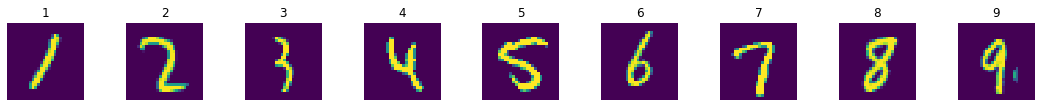

In [6]:
labels = np.unique(data['label'])           # Labels auslesen


# Matplot handling um Achsen zu erstellen
fig, axes = plt.subplots(1, len(labels))    # Plot definieren
fig.set_size_inches(15,4)                   # Größe
fig.tight_layout() 

# Generiert einen Plot mit einem Bild aus jeder Klasse
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

## Datensatz umformen
Die derzeitige Form eines eingelesenen Bildes ist <index, breite, höhe, schichten> mit Index für die Anzahl der Elemente, Breite/Höhe gibt die Bildgröße in Pixel an und Schichten beschreibt die Art des Bildes (3 = RGB).

Um eine Klassifikation durchzuführen, benötigt das System einen Vektor mit maximal 2 Dimensionen. Wir wollen einen Vektor mit <index, pixel_vektor>, wobei index gleich bleibt, um mit den Labels (y-Vektor) übereinzustimmen. Der pixel_vektor ("Daten" entsprechend zum Index im X-Vektor) wird aus den restlichen Ebenen gebildet, um einen 1*n Vektor zu erhalten.  
 

In [7]:
X = np.array(data['data'])                                      # Einlesen der Bilder
print("Original Form: {}".format(X.shape))                      
x = X.reshape(X.shape[0], X.shape[1]* X.shape[2])   # Umformen auf die beschriebene Größe
print("Umgeformter Datensatz der Form: {}".format(x.shape))

y = np.array(data['label'])                                     # Einlesen der Labels
print("Der Index muss mit der Labels größe Übereinstimmen. \nLabels größe: {}".format(y.shape)) #Abgleichen ob die Form übereinstimmt 

Original Form: (54077, 28, 28)
Umgeformter Datensatz der Form: (54077, 784)
Der Index muss mit der Labels größe Übereinstimmen. 
Labels größe: (54077,)


# Abschnitt 2: Erstellen des Modells

## SVM-Model
(1) Datensatz in Trainings/Test Daten aufteilen <br>
(2) Principal component analysis (PCA) definieren <br>
(3) Modell definieren <br>
(4) Genauigkeit auswerten <br>


Zum Einsatz kommt hier die sklearn Bibliothek, welche es ermöglicht, ein bereits existierendes Model einzubinden und nur die Parameter zu definieren. Dadurch sind features wie Skalieren, PCA oder das Trainieren leicht umgesetzt. 

Weitere Dokumentation: <br>
[Model](https://rpubs.com/Sharon_1684/454441) <br>
[SVM Dokumentation](https://scikit-learn.org/stable/modules/svm.html)

### Aufteilen und Transformieren (PCA)
#### (1) Datensatz Teilen
Im ersten Abschnitt der folgenden Zelle wird der Datensatz in Trainings- und Testdaten aufgeteilt. Das ermöglicht das Trainieren und das anschließende Testen des Models 

#### (2) Principal Component Analysis (PCA)
Im zweiten Teil wird eine PCA auf den Datensatz angewandt. Dies ermöglicht, dass nicht alle Pixel als Trainingsdaten herangezogen werden, sondern nur herausstechende Features. 


In [8]:
# Aufteilen des Datensatzes (1)
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)


# (2) Skalieren
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)


#  PCA (2)
pca = PCA(.90)                                  # verwendet 95% der Komponenten und erstellen der "PCA-Instanz"
#pca = PCA(10)                                  # verwendet die 10 wichtigsten Komponenten
pca.fit(X_train)                                # PCA aufgrund von Datensatz auslegen
n_comp = pca.n_components_ 
print(pca.n_components_)                            
X_train = pca.transform(X_train)                # PCA auf Datensatz anwenden
X_test = pca.transform(X_test)                  # PCA auf Test Daten anwenden
pd.Series(y_train).value_counts()               # Evaluieren der Verteilung der Daten

# TOP 5 eigenfaces 

nbr_eigenfaces = 10


eigenfaces = pca.components_[:nbr_eigenfaces]
eigenfaces = eigenfaces.reshape((nbr_eigenfaces, int(SIZE), int(SIZE)))




for i in range(nbr_eigenfaces):

    min_ = np.amin(eigenfaces[i])
    max_ = np.amax(eigenfaces[i])

    tmp = ((eigenfaces[i] - min_) / (max_-min_)) * 255

    filename = "eigenfaces/eigenface" + str(i) + ".png"  
    cv2.imwrite(filename, tmp)
    



90


#### (3) Modell definieren
In der folgenden Zelle wird die Support Vector Machine definiert. Hierzu wird die C-Support Vector Classification von der sklearn-Bibliothek eingefügt. 



##### kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
Gibt den Kernel-Typ an, der im Algorithmus verwendet werden soll. Es muss einer der Typen 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' oder ein Callable sein.

##### probabilitybool, default=False
Ob Wahrscheinlichkeitsschätzungen aktiviert werden sollen. Verlangsamt das System, allerdings ermöglicht es eine 5-fold cross-validation. Genauere Beschreibung: https://scikit-learn.org/stable/modules/svm.html#scores-probabilities

##### random_stateint, RandomState instance or None, default=None
Aktiviert einen Pseudo-Random-Number-Generator, um die Daten zu mischen.


#### Weitere Parameter: 
- break_tiesbool, default=False
- decision_function_shape{‘ovo’, ‘ovr’}, default=’ovr’
- max_iterint, default=-1
- verbosebool, default=False
- class_weightdict or ‘balanced’, default=None
- cache_sizefloat, default=200

Mehr Infos zu den [Parametern](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [9]:
svm = SVC(kernel='linear', probability=True, random_state=42)       # (3) SVM Definition
svm.fit(X_train, y_train)  # Modell Trainieren

SVC(kernel='linear', probability=True, random_state=42)

### (4) Genauigkeit auswerten

In [10]:
y_pred = svm.predict(X_test)                     # Prediction für den Test Datensatz
accuracy = accuracy_score(y_test, y_pred)        # Auswertung
print('Model accuracy: ', accuracy)              # Ausgabe der Genauigkeit

Model accuracy:  0.9352194280078896


# Abschnitt 3: Webcam Implementierung
## Ausführung der Live-Erkennung
In der folgenden Zelle wird ein Kamerastream geöffnet und Frame für Frame eine Prediction durchgeführt. So wie es in dem Demo Example auch passiert ist. Der Unterschied hier ist lediglich, dass die Bilder nicht über vorhandene Daten eingelesen werden,  sondern dynamisch über die Kamera "generiert" werden. 


In [11]:

#libraries
from skimage.transform import resize
from sklearn.decomposition import PCA
import cv2
from IPython.display import clear_output


cv2.namedWindow('Prediction | press q to exit', 0)
i = 0
for filename in os.listdir("demo"):
    img = cv2.imread(os.path.join("demo/",filename), 0)
    height = width
    img = resize(img, (width, height))
    if img is None:
        print(os.path.join("demo/",filename))
        break
    else: 
        # Bild aus einer Matrix in einen Vektor umformen 
        image = img.reshape(1 ,-1)

        # Bild an das Modell anpassen (Skalieren und PCA anwenden)
        image = scaler.transform(image)
        image = pca.transform(image)

        #Predict 
        y_new_prob  = svm.predict_proba(image)
        y_new  = svm.predict(image)

        # Wahrscheinlichkeit des Bildes (bei einer Klassifizierung) in Prozent umrechnen
        prob = y_new_prob[0]*100


        clear_output(wait=True)
        print("***************")
        i = i+1
        print("Example Image: {}".format(i))
        #Auswertung für die "live" Darstellung
        print("Predicted Number: ({})".format(y_new))
        print("{:.2f}%".format(prob[int(y_new)-1]))
            
        
        #Ausgabe 
        cv2.imshow('Prediction | press q to exit', img)
        #User Input für das beenden des Darstellen  
        if cv2.waitKey(0) & 0xFF == ord('q'):    
            break


# Stream schließen und Window Handling

cv2.destroyAllWindows()

***************
Example Image: 5
Predicted Number: (['7'])
100.00%
